<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'inspection_persons', 'inspection_status_summary', 'lastUpdate', 'main_summary'])

In [5]:
# 日毎の数
patients_count = [data['小計'] for data in j_res['patients_summary']['data']]

In [6]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [14]:
# 日付をインデックスにした日毎の数のデータフレーム
patients_df = pd.DataFrame(
    {'patients_count': patients_count},
    index=pd.date_range(
        start=utc_datestr_to_jst_date(j_res['patients_summary']['data'][0]['日付']),
        end=utc_datestr_to_jst_date(j_res['patients_summary']['data'][-1]['日付']),
        freq='D'))
patients_df['datetime'] = patients_df.index
patients_df.tail()

,patients_count,datetime
2020-07-27 17:00:00+09:00,131,2020-07-27 17:00:00+09:00
2020-07-28 17:00:00+09:00,266,2020-07-28 17:00:00+09:00
2020-07-29 17:00:00+09:00,250,2020-07-29 17:00:00+09:00
2020-07-30 17:00:00+09:00,367,2020-07-30 17:00:00+09:00
2020-07-31 17:00:00+09:00,463,2020-07-31 17:00:00+09:00


In [19]:
# 7日移動平均
seven_day_mov_ave = patients_df['patients_count'].rolling('7D').mean()
seven_day_mov_center_ave = patients_df['patients_count'].rolling(7, center=True).mean()
patients_df['7d_mov_ave'] = seven_day_mov_ave
patients_df['7d_mov_center_ave'] = seven_day_mov_center_ave
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave
2020-07-27 17:00:00+09:00,131,2020-07-27 17:00:00+09:00,252.285714,258.285714
2020-07-28 17:00:00+09:00,266,2020-07-28 17:00:00+09:00,256.428571,287.285714
2020-07-29 17:00:00+09:00,250,2020-07-29 17:00:00+09:00,258.142857,NaN
2020-07-30 17:00:00+09:00,367,2020-07-30 17:00:00+09:00,258.285714,NaN
2020-07-31 17:00:00+09:00,463,2020-07-31 17:00:00+09:00,287.285714,NaN


In [20]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
patients_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in patients_df.index]
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,week_num
2020-07-27 17:00:00+09:00,131,2020-07-27 17:00:00+09:00,252.285714,258.285714,'20w31
2020-07-28 17:00:00+09:00,266,2020-07-28 17:00:00+09:00,256.428571,287.285714,'20w31
2020-07-29 17:00:00+09:00,250,2020-07-29 17:00:00+09:00,258.142857,NaN,'20w31
2020-07-30 17:00:00+09:00,367,2020-07-30 17:00:00+09:00,258.285714,NaN,'20w31
2020-07-31 17:00:00+09:00,463,2020-07-31 17:00:00+09:00,287.285714,NaN,'20w31


In [21]:
# 曜日の列をセット
patients_df['week_day'] = [d.strftime('%a') for d in patients_df.index]
patients_df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,week_num,week_day
2020-07-17 17:00:00+09:00,293,2020-07-17 17:00:00+09:00,202.571429,219.000000,'20w29,Fri
2020-07-18 17:00:00+09:00,290,2020-07-18 17:00:00+09:00,214.571429,232.428571,'20w29,Sat
2020-07-19 17:00:00+09:00,188,2020-07-19 17:00:00+09:00,212.000000,242.857143,'20w29,Sun
2020-07-20 17:00:00+09:00,168,2020-07-20 17:00:00+09:00,219.000000,254.285714,'20w30,Mon
2020-07-21 17:00:00+09:00,237,2020-07-21 17:00:00+09:00,232.428571,249.571429,'20w30,Tue
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143,250.285714,'20w30,Wed
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714,257.571429,'20w30,Thu
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429,252.285714,'20w30,Fri
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714,256.428571,'20w30,Sat
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429,258.142857,'20w30,Sun


In [22]:
# 週毎に集計
groupby_week_num = patients_df.groupby('week_num')
groupby_week_num

In [23]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': patients_df['week_num'].unique(),
    'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
week_num_df.tail()

,week_num,week_mean,week_sum
2020-07-05 17:00:00+09:00,'20w27,93.142857,652
2020-07-12 17:00:00+09:00,'20w28,166.000000,1162
2020-07-19 17:00:00+09:00,'20w29,212.000000,1484
2020-07-26 17:00:00+09:00,'20w30,257.571429,1803
2020-07-31 17:00:00+09:00,'20w31,295.400000,1477


In [24]:
df = pd.concat([
                patients_df,
                week_num_df.loc[:, ['week_mean', 'week_sum']]
                ], axis=1)
df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,week_num,week_day,week_mean,week_sum
2020-07-17 17:00:00+09:00,293,2020-07-17 17:00:00+09:00,202.571429,219.000000,'20w29,Fri,NaN,NaN
2020-07-18 17:00:00+09:00,290,2020-07-18 17:00:00+09:00,214.571429,232.428571,'20w29,Sat,NaN,NaN
2020-07-19 17:00:00+09:00,188,2020-07-19 17:00:00+09:00,212.000000,242.857143,'20w29,Sun,212.000000,1484.0
2020-07-20 17:00:00+09:00,168,2020-07-20 17:00:00+09:00,219.000000,254.285714,'20w30,Mon,NaN,NaN
2020-07-21 17:00:00+09:00,237,2020-07-21 17:00:00+09:00,232.428571,249.571429,'20w30,Tue,NaN,NaN
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143,250.285714,'20w30,Wed,NaN,NaN
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714,257.571429,'20w30,Thu,NaN,NaN
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429,252.285714,'20w30,Fri,NaN,NaN
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714,256.428571,'20w30,Sat,NaN,NaN
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429,258.142857,'20w30,Sun,257.571429,1803.0


### グラフ出力

In [25]:
### 日毎の数
x = df.index
y1_1 = df['patients_count']
y1_2 = df['7d_mov_ave']
y1_3 = df['7d_mov_center_ave']
y1_4 = df['week_mean']

In [26]:
### 週毎の数
x2 = week_num_df['week_num']
#y2_1 = week_num_df['week_mean']
y2_2 = week_num_df['week_sum']

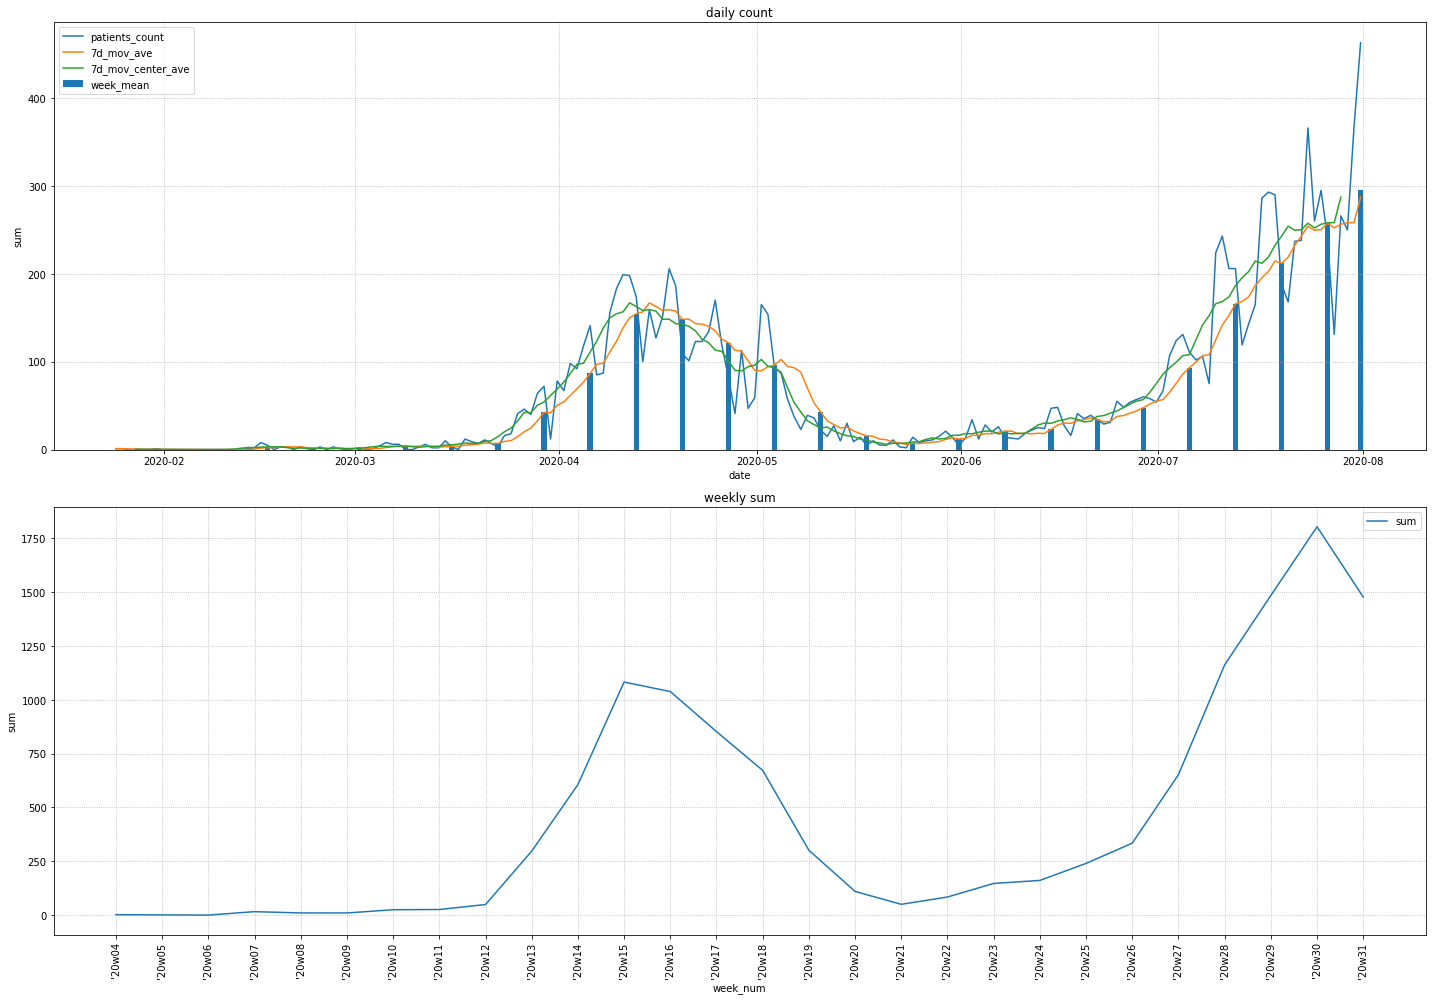

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='7d_mov_ave')
ax[0].plot(x, y1_3, label='7d_mov_center_ave')
ax[0].bar(x, y1_4, label='week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
#ax[1].set_title('weekly mean')
#ax[1].set_xticklabels(labels=x2, rotation=90)
#ax[1].set_xlabel('week_num')
#ax[1].set_ylabel('mean')
#ax[1].plot(x2, y2_1, label='mean')
#ax[1].grid(linestyle=':')
#ax[1].legend()

### 週毎の合計
ax[1].set_title('weekly sum')
ax[1].set_xticklabels(labels=x2, rotation=90)
ax[1].set_xlabel('week_num')
ax[1].set_ylabel('sum')
ax[1].plot(x2, y2_2, label='sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [28]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [29]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [30]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [31]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [33]:
ds_df = pd.DataFrame({
    'year': df.index.strftime('%Y'), # 年
    'month': df.index.strftime('%m'), # 月
    'day': df.index.strftime('%d'), # 日
    'week_day': df['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
ds_df['passed'] = [(d - df['datetime'][0]).days for d in df['datetime']]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df['datetime']]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df['datetime']]
# 日毎の数
ds_df['patients_count'] = df['patients_count']
# 7日間移動平均
ds_df['7d_mov_ave'] = df['7d_mov_ave']
ds_df['7d_mov_center_ave'] = df['7d_mov_center_ave']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(120)

,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_center_ave
70,2020,04,03,1,0,0,0,0,0,0,70,0,0,92,69.000000,97.000000
71,2020,04,04,0,0,1,0,0,0,0,71,0,0,118,76.714286,98.285714
72,2020,04,05,0,0,0,1,0,0,0,72,0,0,141,86.571429,111.000000
73,2020,04,06,0,1,0,0,0,0,0,73,0,0,85,97.000000,123.142857
74,2020,04,07,0,0,0,0,0,1,0,74,1,0,87,98.285714,138.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2020,07,27,0,1,0,0,0,0,0,185,0,111,131,252.285714,258.285714
186,2020,07,28,0,0,0,0,0,1,0,186,0,112,266,256.428571,287.285714
187,2020,07,29,0,0,0,0,0,0,1,187,0,113,250,258.142857,NaN
188,2020,07,30,0,0,0,0,1,0,0,188,0,114,367,258.285714,NaN


In [34]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               190 non-null    object 
 1   month              190 non-null    object 
 2   day                190 non-null    object 
 3   Fri                190 non-null    uint8  
 4   Mon                190 non-null    uint8  
 5   Sat                190 non-null    uint8  
 6   Sun                190 non-null    uint8  
 7   Thu                190 non-null    uint8  
 8   Tue                190 non-null    uint8  
 9   Wed                190 non-null    uint8  
 10  passed             190 non-null    int64  
 11  emergency          190 non-null    int64  
 12  em_passed          190 non-null    int64  
 13  patients_count     190 non-null    int64  
 14  7d_mov_ave         190 non-null    float64
 15  7d_mov_center_ave  184 non-null    float64
dtypes: float64(2), int64(4), o

In [35]:
ds_df.describe()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_center_ave
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,184.000000
mean,0.147368,0.142105,0.142105,0.142105,0.142105,0.142105,0.142105,94.500000,0.257895,35.105263,66.794737,61.610000,63.597826
std,0.355409,0.350081,0.350081,0.350081,0.350081,0.350081,0.350081,54.992424,0.438632,38.451364,87.322034,74.756649,75.139687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.250000,0.000000,0.000000,3.250000,3.607143,4.071429
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000,0.000000,20.500000,26.500000,24.500000,28.214286
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.750000,1.000000,67.750000,106.750000,100.500000,103.642857
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,189.000000,1.000000,115.000000,463.000000,287.285714,287.285714


In [36]:
ds_df.corr()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_center_ave
Fri,1.000000e+00,-0.169204,-0.169204,-0.169204,-0.169204,-0.169204,-0.169204,-3.847040e-18,-0.007502,0.007764,0.104976,0.017679,-0.006895
Mon,-1.692036e-01,1.000000,-0.165644,-0.165644,-0.165644,-0.165644,-0.165644,-3.710232e-03,0.001269,-0.004655,-0.111543,-0.008601,0.006091
Sat,-1.692036e-01,-0.165644,1.000000,-0.165644,-0.165644,-0.165644,-0.165644,-1.855116e-02,0.001269,-0.017233,0.035229,-0.019186,0.001017
Sun,-1.692036e-01,-0.165644,-0.165644,1.000000,-0.165644,-0.165644,-0.165644,-1.113070e-02,0.001269,-0.010944,-0.030195,-0.012350,0.008453
Thu,-1.692036e-01,-0.165644,-0.165644,-0.165644,1.000000,-0.165644,-0.165644,1.855116e-02,0.001269,0.014998,0.078845,0.016859,-0.010791
Tue,-1.692036e-01,-0.165644,-0.165644,-0.165644,-0.165644,1.000000,-0.165644,3.710232e-03,0.001269,0.001634,-0.034176,-0.000938,0.019619
Wed,-1.692036e-01,-0.165644,-0.165644,-0.165644,-0.165644,-0.165644,1.000000,1.113070e-02,0.001269,0.008316,-0.044734,0.006269,-0.017900
passed,-3.847040e-18,-0.003710,-0.018551,-0.011131,0.018551,0.003710,0.011131,1.000000e+00,0.037618,0.942970,0.582513,0.605382,0.594830
emergency,-7.502486e-03,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,3.761833e-02,1.000000,-0.170707,0.104302,0.210405,0.147528
em_passed,7.763705e-03,-0.004655,-0.017233,-0.010944,0.014998,0.001634,0.008316,9.429700e-01,-0.170707,1.000000,0.557170,0.565060,0.550064
